In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import time

import os
import subprocess
import shutil

from debugger import message_checkpoints
from utils import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Latex-like font for plots
# Note: if LaTeX is not installed, do not run this cell
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr10",
    "text.latex.preamble": r"\usepackage{amsmath, amssymb}",
    "font.size": 16})

# Ex.1 - Scaling of the matrix-matrix multiplication.

In [3]:
Nmin, Nmax = 1000, 5000 # dimensions I want to test my program
step = 1000
loops = np.arange(Nmin, Nmax+1, step)

# define all the file paths
fortran_file = "/Users/giacomogasparotto/POD/QuantumComputing-exercises/Ex3/Ex1-Gasparotto-CODE.f90"
executable = "/Users/giacomogasparotto/POD/QuantumComputing-exercises/Ex3/ex1"
results_directory = "/Users/giacomogasparotto/POD/QuantumComputing-exercises/Ex3/matrix_dimensions"

# create a directory to store the results
os.makedirs(results_directory, exist_ok=True)

# compile fortran file if the executable does not already exist
if not os.path.isfile(executable):
    print("Compiling fortran file...")
    subprocess.run([
    "gfortran",
    "-Ofast",
    "-fno-range-check",
    fortran_file,
    "-o", executable], check=True)


print(f"Run Fortran program for {len(loops)} matrix dimensions.")
message_checkpoints(0, "=== MULTIPLYING MATRICES ===")
for d in loops:
    subprocess.run([executable], input=f"{d}\n".encode(), check=True)

    # create a subdirectory for this specific loop and store the results inside
    run_folder = os.path.join(results_directory, f"dim_{d}")
    os.makedirs(run_folder, exist_ok=True)

    for filename in ["row_col.dat", "col_row.dat", "matmul.dat"]:
        if os.path.exists(filename):
            shutil.move(filename, os.path.join(run_folder, filename))

# Delete the executable
os.remove(executable)

Run Fortran program for 5 matrix dimensions.
=== MULTIPLYING MATRICES ===
 Performing multiplication for matrix dimension:         1000 x        1000 ...
 Performing multiplication for matrix dimension:         2000 x        2000 ...
 Performing multiplication for matrix dimension:         3000 x        3000 ...
 Performing multiplication for matrix dimension:         4000 x        4000 ...
 Performing multiplication for matrix dimension:         5000 x        5000 ...


In [4]:
# Define lists to store the results
dims = []
CPUtime_rowbycol = []
CPUtime_colbyrow = []
CPUtime_matmul = []

# Loop over the folders to extract the results
folders = sorted(
    [f for f in os.listdir(results_directory) if f.startswith("dim_")],
    key=lambda x: int(x.split("_")[1])
)

for folder in folders:
    if folder.startswith("dim_"):
        d = int(folder.split("_")[1]) 
        dims.append(d)

        folder_path = os.path.join(results_directory, folder)

        # Load data for different multiplication methods
        data = np.loadtxt(os.path.join(folder_path, "row_col.dat"))
        CPUtime_rowbycol.append(data[1])

        data = np.loadtxt(os.path.join(folder_path, "col_row.dat"))
        CPUtime_colbyrow.append(data[1])

        data = np.loadtxt(os.path.join(folder_path, "matmul.dat"))
        CPUtime_matmul.append(data[1])

# Convert lists to numpy arrays
dims = np.array(dims)
CPUtime_rowbycol = np.array(CPUtime_rowbycol)
CPUtime_colbyrow = np.array(CPUtime_colbyrow)
CPUtime_matmul = np.array(CPUtime_matmul)

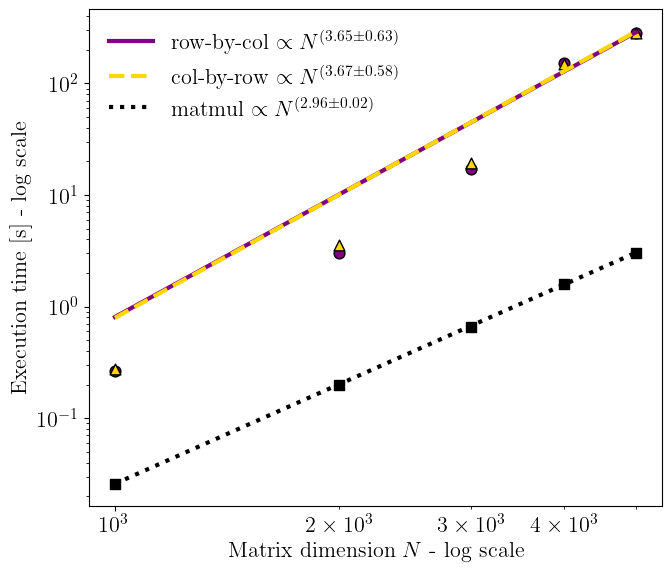

In [5]:
# Fit the points to compute the variables
def time_scaling(N, a, b):
    return a*N**b

popt_rowcol, pcov_rowcol = curve_fit(time_scaling, dims, CPUtime_rowbycol, maxfev=1000)
popt_colrow, pcov_colrow = curve_fit(time_scaling, dims, CPUtime_colbyrow, maxfev=1000)
popt_matmul, pcov_matmul = curve_fit(time_scaling, dims, CPUtime_matmul, maxfev=1000)

# Plot the results
fig, ax = plt.subplots(figsize=(7, 6))

ax.set_xscale("log")
ax.set_yscale("log")

x = np.linspace(np.min(dims), np.max(dims), 1000)

# Row-by-col
ax.scatter(dims, CPUtime_rowbycol, s=60, edgecolors="black", c="purple")
ax.plot(x, time_scaling(x, *popt_rowcol), linestyle="solid", linewidth=3, c="purple",
        label=r"row-by-col $\propto N^{(%.2f \pm %.2f)}$" % (popt_rowcol[1], np.sqrt(pcov_rowcol[1,1])))

# Col-by-row
ax.scatter(dims, CPUtime_colbyrow, s=60, marker="^", edgecolors="black", c="gold")
ax.plot(x, time_scaling(x, *popt_colrow), linestyle="dashed", linewidth=3, c="gold",
        label=r"col-by-row $\propto N^{(%.2f \pm %.2f)}$" % (popt_colrow[1], np.sqrt(pcov_colrow[1,1])))

# Built-in matmul
ax.scatter(dims, CPUtime_matmul, s=60, marker="s", edgecolors="black", c="black")
ax.plot(x, time_scaling(x, *popt_matmul), linestyle="dotted", linewidth=3, c="black",
        label=r"matmul $\propto N^{(%.2f \pm %.2f)}$" % (popt_matmul[1], np.sqrt(pcov_matmul[1,1])))

plt.legend(loc="best", frameon=False, fontsize=16)
plt.xlabel(r"Matrix dimension $N$ - log scale") 
plt.ylabel(r"Execution time [s] - log scale")
plt.tight_layout()

plt.savefig("matmul_efficiency.pdf")

In [6]:
# Delete the "matrix_dimension" folder
shutil.rmtree(results_directory)

# Ex.2 - Eigenproblem.
# Ex.3 - Random Matrix theory.

You have correctly generated an hermitian matrix!


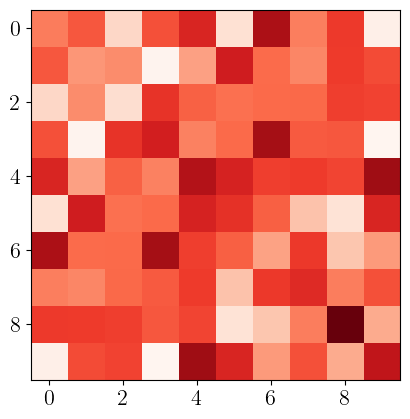

In [7]:
# Generate a test matrix
A = generate_hermitian_matrix(10, distr="uniform")

# Basic visualization of the generated hermitian matrix
plt.imshow(A, cmap="Reds")

In [8]:
# Compute eigenvals normalized spacing
# note: the largest spacing between eigenvalues has been discarded into the "compute_eigenvals_spacing" function
s = compute_eigenvals_spacing(A)
print(s)

[0.30057607 0.75796455 0.96458623 1.8016164  0.7230403  0.14960929
 1.3870561  1.91555105]


In [9]:
# Try to generate them for different kinds of matrices
m1 = generate_hermitian_matrix(5000, distr="uniform")
s1 = compute_eigenvals_spacing(m1)

m2 = generate_hermitian_matrix(5000, distr="uniform", low=-1., high=1.)
s2 = compute_eigenvals_spacing(m2)

m3 = generate_hermitian_matrix(5000, distr="normal")  
s3 = compute_eigenvals_spacing(m3)

m4 = generate_hermitian_matrix(5000, distr="normal", mean=5., std=0.5)
s4 = compute_eigenvals_spacing(m4)

You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!


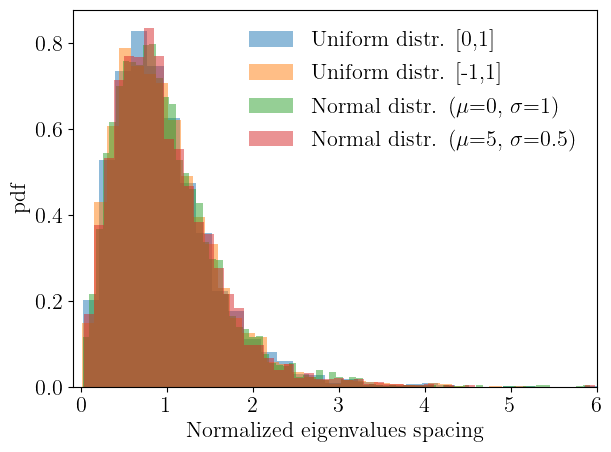

In [10]:
# plot the spacing distributions (not exactly what asked by the problem but just to have an idea)
plt.hist(s1, bins=100, alpha=0.5, label=r"Uniform distr. [0,1]", density=True)
plt.hist(s2, bins=100, alpha=0.5, label=r"Uniform distr. [-1,1]", density=True)
plt.hist(s3, bins=100, alpha=0.5, label=r"Normal distr. ($\mu$=0, $\sigma$=1)", density=True)
plt.hist(s4, bins=100, alpha=0.5, label=r"Normal distr. ($\mu$=5, $\sigma$=0.5)", density=True)

plt.legend(loc="best", frameon=False)
plt.xlabel("Normalized eigenvalues spacing")
plt.ylabel("pdf")
plt.xlim(-0.1, 6)
plt.tight_layout()
plt.savefig("eigenvals_spacing_counts.pdf")

### Real hermitian matrix

In [11]:
# Controls
matrix_dim = 1000
n_reps = 50

In [ ]:
# Generate eigenvalues spacings for 'n_reps' real hermitian matrices
spacings = []

for dim in np.repeat(matrix_dim, n_reps):
    A = generate_hermitian_matrix(dim)
    s = compute_eigenvals_spacing(A).real
    spacings.append(s)

all_sA = np.concatenate(spacings)

You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!


a: 2.7163716716455086 +/- 0.1343332611336676
b: 1.4158542594084347 +/- 0.05090679888885139
alpha: 1.153223299790645 +/- 0.02741901223854693
beta: 1.49231326235645 +/- 0.03095044309721798


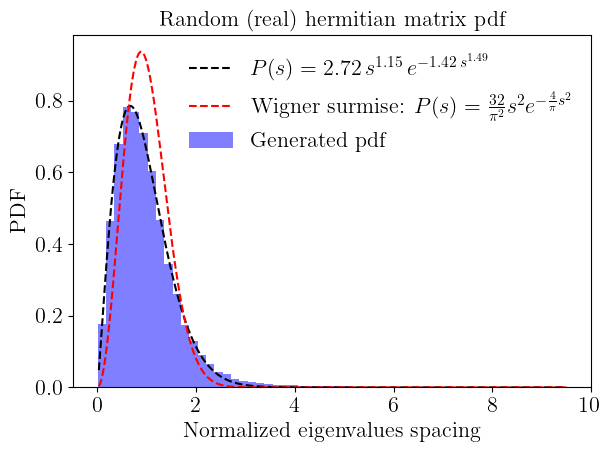

In [ ]:
# Plot pdfs
bin_edgesA, countsA = compute_P(all_sA, nbins=100)
plot_P(bin_edgesA, countsA, title="Random (real) hermitian matrix", color="blue", filename="real_hermitian_distr.pdf")

### Real diagonal matrix

In [ ]:
# Generate eigenvalues spacings for 'n_reps' real diagonal matrices
spacings = []

for dim in np.repeat(matrix_dim, n_reps):
    B = generate_diagonal_matrix(dim, distr="uniform")
    s = compute_eigenvals_spacing(B).real
    spacings.append(s)

all_sB = np.concatenate(spacings)

You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal matrix!
You have correctly generated a diagonal 

a: 0.9267398985842702 +/- 0.019300487302994298
b: 0.9290472315212274 +/- 0.022365771218565474
alpha: -0.03267809301293702 +/- 0.00671959003612554
beta: 1.0300686277930735 +/- 0.015498256195628906


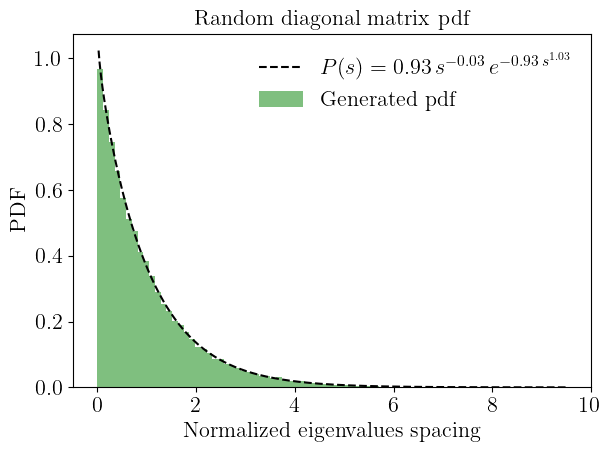

In [ ]:
# Plot pdfs
bin_edgesB, countsB = compute_P(all_sB, nbins=100)
plot_P(bin_edgesB, countsB, title="Random diagonal matrix", color="green", filename="real_diagonal_distr.pdf", fit_WS=False)

### Complex hermitian matrix

In [ ]:
# Generate eigenvalues spacings for 'n_reps' complex hermitian matrices
spacings = []

for dim in np.repeat(matrix_dim, n_reps):
    C = generate_hermitian_matrix(dim, complex=True)
    s = compute_eigenvals_spacing(C)
    spacings.append(s)

all_sC = np.concatenate(spacings)

You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!
You have correctly generated an hermitian matrix!


a: 13.82487074553651 +/- 2.8959541104754267
b: 2.824090463832842 +/- 0.21155206645768068
alpha: 2.610280420198517 +/- 0.11672742384913273
beta: 1.3301254217780993 +/- 0.05530649330996295


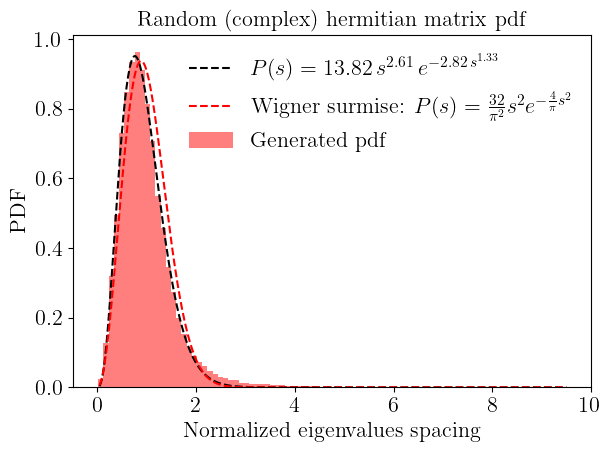

In [ ]:
# Plot pdfs
bin_edgesC, countsC = compute_P(all_sC, nbins=100)
plot_P(bin_edgesC, countsC, title="Random (complex) hermitian matrix", color="red", filename="complex_hermitian_distr.pdf")

### Sparse matrix

In [ ]:
# Generate eigenvalues spacings for 'n_reps' sparse matrices
spacings = []

for dim in np.repeat(matrix_dim, n_reps):
    S = generate_sparse_random_matrix(matrix_dim, density=0.01)
    s = compute_eigenvals_spacing(S)
    spacings.append(s)

all_sS = np.concatenate(spacings)

a: 4.578376591233516 +/- 0.31072062167712816
b: 1.9994636302076143 +/- 0.0695967744490994
alpha: 1.2978003654500037 +/- 0.03198143228935983
beta: 1.255430222364863 +/- 0.0264300839180918


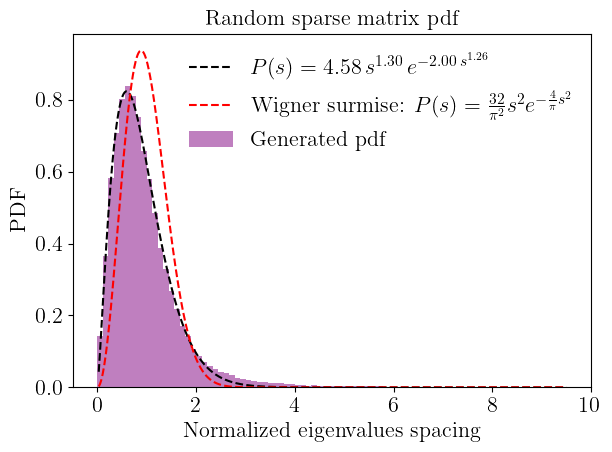

In [ ]:
# Plot pdfs
bin_edgesS, countsS = compute_P(all_sS, nbins=250)
plot_P(bin_edgesS, countsS, title="Random sparse matrix", color="purple", filename="real_sparse_distr.pdf")

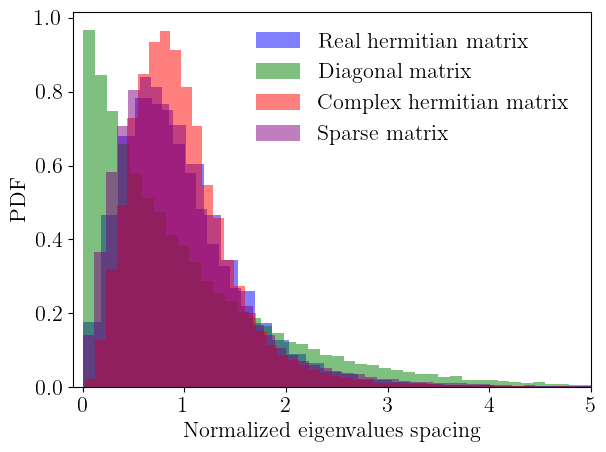

In [ ]:
# Overlap each distribution for a visual comparison
fig, ax = plt.subplots()

plot_P(bin_edgesA, countsA, label="Real hermitian matrix", color="blue", fit=False)
plot_P(bin_edgesB, countsB, label="Diagonal matrix", color="green", fit=False)
plot_P(bin_edgesC, countsC, label="Complex hermitian matrix", color="red", fit=False)
plot_P(bin_edgesS, countsS, label="Sparse matrix", color="purple", fit=False)

ax.set_xlim(-0.1, 5)
fig.savefig("all_distributions_comparison.pdf")

Diagonalization time performances

In [ ]:
# Check time performances for different sizes of the matrices

# Define matrix sizes
dim_min = 1000
dim_max = 10000
dim_step = 1000
matrix_sizes = np.arange(dim_min, dim_max+dim_step, dim_step)

# Lists to store times
timeA = []
timeB = []
timeC = []
timeS = []

nloop = 1
for md in matrix_sizes:
    print(f"\n\n=== LOOP {nloop}/{len(matrix_sizes)} ===")
    print(f"Matrix dimension {md}x{md}\n")
    
    # Generate matrices and store times
    message_checkpoints(0, "Generating real hermitian matrices...")
    startA = time.time()
    A = generate_hermitian_matrix(md)
    sA = compute_eigenvals_spacing(A)
    stopA = time.time()
    timeA.append(stopA - startA)

    message_checkpoints(0, "Generating diagonal matrices...")
    startB = time.time()
    B = generate_diagonal_matrix(md)
    sB = compute_eigenvals_spacing(B)
    stopB = time.time()
    timeB.append(stopB - startB)

    message_checkpoints(0, "Generating complex hermitian matrices...")
    startC = time.time()
    C = generate_hermitian_matrix(md, complex=True)
    sC = compute_eigenvals_spacing(C)
    stopC = time.time()
    timeC.append(stopC - startC)

    message_checkpoints(0, "Generating sparse matrices...")
    startS = time.time()
    S = generate_sparse_random_matrix(md, density=0.01)
    sS = compute_eigenvals_spacing(S)
    stopS = time.time()
    timeS.append(stopS - startS)  

    nloop=nloop+1  



=== LOOP 1/10 ===
Matrix dimension 1000x1000

Generating real hermitian matrices...
You have correctly generated an hermitian matrix!
Generating diagonal matrices...
You have correctly generated a diagonal matrix!
Generating complex hermitian matrices...
You have correctly generated an hermitian matrix!
Generating sparse matrices...


=== LOOP 2/10 ===
Matrix dimension 2000x2000

Generating real hermitian matrices...
You have correctly generated an hermitian matrix!
Generating diagonal matrices...
You have correctly generated a diagonal matrix!
Generating complex hermitian matrices...
You have correctly generated an hermitian matrix!
Generating sparse matrices...


=== LOOP 3/10 ===
Matrix dimension 3000x3000

Generating real hermitian matrices...
You have correctly generated an hermitian matrix!
Generating diagonal matrices...
You have correctly generated a diagonal matrix!
Generating complex hermitian matrices...
You have correctly generated an hermitian matrix!
Generating sparse m

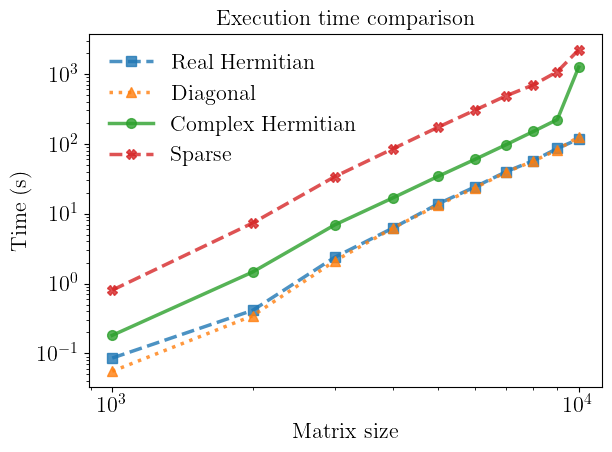

In [22]:
# Plot time results
plt.xscale("log")
plt.yscale("log")

plt.plot(matrix_sizes, timeA, marker='s', markersize=7, linestyle="dashed", linewidth=2.5, alpha=0.8, label="Real Hermitian")
plt.plot(matrix_sizes, timeB, marker='^', markersize=7, linestyle="dotted", linewidth=2.5, alpha=0.8,  label="Diagonal")
plt.plot(matrix_sizes, timeC, marker='o', markersize=7, linestyle="solid", linewidth=2.5, alpha=0.8,  label="Complex Hermitian")
plt.plot(matrix_sizes, timeS, marker='X', markersize=7, linestyle="dashed", linewidth=2.5, alpha=0.8,  label="Sparse")

plt.xlabel("Matrix size", fontsize=16)
plt.ylabel("Time (s)", fontsize=16)
plt.title("Execution time comparison", fontsize=16)

plt.legend(loc="upper left", frameon=False, fontsize=16)
plt.tight_layout()
plt.tight_layout()

plt.savefig("time_comparison.pdf")